# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image models on [MNIST](http://yann.lecun.com/exdb/mnist/) using Estimator.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


## Exploring the data

The MNIST dataset is already included in tensorflow through the keras datasets module. Let's load it and get a sense of the data.

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

print(x_train[0].shape)
tf.print(tf.size(tf.unique(y_train).y))

(28, 28)
10


In [3]:
HEIGHT, WIDTH = x_train[0].shape
NCLASSES = tf.size(tf.unique(y_train).y)

Each image is 28 x 28 pixels and represents a digit from 0 to 9. These images are black and white, so each pixel is a value from 0 (white) to 255 (black). Raw numbers can be hard to interpret sometimes, so we can plot the values to see the handwritten digit as an image.

The label for image number 12 is 9


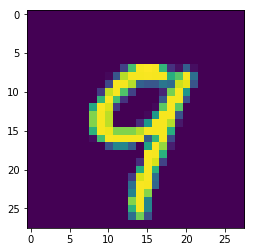

In [4]:
IMGNO = 12
# Uncomment to see raw numerical values.
# print(x_test[IMGNO])
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));
print("The label for image number " + str(IMGNO) + " is " + str(y_test[IMGNO]))

## Define the model.
Let's start with a very simple linear classifier. This was the first method to be tried on MNIST in 1998. All our models will have this basic interface -- they will take an image and return logits.

In [5]:
# Using low-level tensorflow
def linear_model(img):
    X = tf.reshape(tensor=img, shape=[-1, HEIGHT*WIDTH]) #flatten
    W = tf.get_variable(
        name="W",
        shape=[HEIGHT*WIDTH, NCLASSES],
        initializer=tf.truncated_normal_initializer(stddev=0.1, seed=1))
    b = tf.get_variable(
        name="b", shape=[NCLASSES], initializer=tf.zeros_initializer)
    ylogits = tf.matmul(a=X, b=W) + b
    return ylogits

Note we can also build our linear classifer using the tf.keras API. Notice when using tf.keras we don't have to define or initialize our weights and biases. This happens automatically for us in the background. We can also add a softmax layer to transform the logits into probabilities. Finally, we can compile the model using categorical crossentropy in order to strongly penalize incorrect predictions with high confidence.

When building more complex models such as DNNs and CNNs our code will be much more readable by using the tf.keras API. Let's get one working so we can test it and use it as a benchmark.

In [6]:
# Using tf.layers API
def linear_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NCLASSES),
        tf.keras.layers.Softmax()
    ])

    # Model is the full model w/o custom layers
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Write Input Functions

As usual, we need to specify input functions for training and evaluating. We'll scale each pixel value so it's a decimal value between 0 and 1 as a way of normalizing the data.

In [7]:
BUFFER_SIZE = 5000
BATCH_SIZE = 100
NUM_EPOCHS = 10
STEPS_PER_EPOCH = 100

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

def create_input_fn(mode):
    def input_fn():
        train_key = tf.estimator.ModeKeys.TRAIN
        dataset = (x_train, y_train) if mode == train_key else (x_test, y_test)
        dataset = tf.data.Dataset.from_tensor_slices(dataset)
        dataset = dataset.map(scale).batch(BATCH_SIZE)
        if mode == train_key:
            print("Repeating training dataset indefinitely")
            dataset = dataset.shuffle(BUFFER_SIZE).repeat()
        return dataset
    return input_fn

Time to train the model! The original MNIST linear classify had an error rate of 12%. Quite an acheivement at the time, but we can do better with other model types. For now, let's set it as a unit test to beat the original.

In [8]:
model = linear_model()

OUTDIR = "mnist/learned"
checkpoint_path = '{}/checkpoints/mnist'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_weights_only=True, verbose=1)

train_data = create_input_fn('train')()
validation_data = create_input_fn('test')()

history = model.fit(
    train_data, 
    validation_data=validation_data,
    epochs=NUM_EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=2, # 0=silent, 1=progress bar, 2=one line per epoch
    callbacks=[cp_callback]
)

Repeating training dataset indefinitely
Epoch 1/10


W0912 01:45:48.264009 140289595434752 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: saving model to mnist/learned/checkpoints/mnist
100/100 - 17s - loss: 1.3342 - accuracy: 0.4948 - val_loss: 0.7920 - val_accuracy: 0.8386
Epoch 2/10

Epoch 00002: saving model to mnist/learned/checkpoints/mnist
100/100 - 1s - loss: 0.6763 - accuracy: 0.8426 - val_loss: 0.5566 - val_accuracy: 0.8706
Epoch 3/10

Epoch 00003: saving model to mnist/learned/checkpoints/mnist
100/100 - 1s - loss: 0.5213 - accuracy: 0.8722 - val_loss: 0.4672 - val_accuracy: 0.8844
Epoch 4/10

Epoch 00004: saving model to mnist/learned/checkpoints/mnist
100/100 - 1s - loss: 0.4582 - accuracy: 0.8779 - val_loss: 0.4172 - val_accuracy: 0.8940
Epoch 5/10

Epoch 00005: saving model to mnist/learned/checkpoints/mnist
100/100 - 1s - loss: 0.4321 - accuracy: 0.8764 - val_loss: 0.3886 - val_accuracy: 0.8990
Epoch 6/10

Epoch 00006: saving model to mnist/learned/checkpoints/mnist
100/100 - 1s - loss: 0.3997 - accuracy: 0.8800 - val_loss: 0.3698 - val_accuracy: 0.9036
Epoch 7/10

Epoch 00007: saving model 

In [15]:
import unittest

benchmark_error = .12
benchmark_accuracy = 1 - benchmark_error

class TestModelAccuracy(unittest.TestCase):
    def test_last_accuracy(self):
        self.assertGreater(history.history['accuracy'][-1], benchmark_accuracy)
        
TestModelAccuracy().test_last_accuracy()

## Write Custom Estimator
I could have simply used a canned LinearClassifier, but later on, I will want to use different models, and so let's write a custom estimator

In [116]:
def train_and_evaluate(output_dir, hparams):
    train_spec = tf.estimator.TrainSpec(
        input_fn=create_input_fn('train'),
        max_steps=hparams["train_steps"])
    eval_spec = tf.estimator.EvalSpec(
        input_fn=create_input_fn('test'),
        steps=STEPS_PER_EPOCH)
    model = linear_model()
    estimator = tf.keras.estimator.model_to_estimator(
      keras_model=model, model_dir=output_dir
    )
    return tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec) 

 tf.estimator.train_and_evaluate does distributed training.

This is the main() function

In [117]:
OUTDIR = "mnist/learned"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"train_steps": 1000, "learning_rate": 0.01}
train_and_evaluate(OUTDIR, hparams)

Repeating training dataset indefinitely


({'accuracy': 0.8864, 'global_step': 1000, 'loss': 0.4121501}, [])

I got:

`Saving dict for global step 1000: accuracy = 0.9158, global_step = 1000, loss = 0.29720208`

In other words, we achieved 91.6% accuracy with the simple linear model!

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>